<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/VI_DAMM_0903_YS1_lr1e_3_hd20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  # mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  truth_theta = {
    'log_mu': np.log(mu),
    'log_sigma': np.log(sigma),
    'log_psi': np.log(psi),
    'log_omega': np.log(omega),
    "log_lambda0": np.log(lambda0_arr),
    'log_pi': np.log(pi_arr),
    'log_tau': np.log(tau_arr)
  }

  return xxx[:,:n_features], xxx[:,n_features], xxx, truth_theta

  #return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(Y.shape[0], 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

In [4]:
class BasicForwardNet(nn.Module):
  """Encoder for when data is input without any encoding"""
  def __init__(self, input_dim, output_dim, hidden_dim = 20):
    super().__init__()
    
    self.input = nn.Linear(input_dim, hidden_dim)
    #self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        
    self.linear1 = nn.ModuleList(
        [nn.Linear(hidden_dim, hidden_dim) for i in range(5)]
    )

    self.output = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    out = F.relu(self.input(x))
    
    #out = F.relu(self.linear1(out))

    for net in self.linear1:
      out = F.relu(net(out))
    
    out = self.output(out)
        
    return F.softmax(out, dim=1), F.log_softmax(out, dim=1) ## r/v/d log_r/log_v/log_d

In [5]:
def compute_joint_probs(Theta, Y, S):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])
  
  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rzd0 = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_vgd1 = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]

  #remove_indices = np.tril_indices(nc, -1) ## remove indices
  #log_rd1g[:, remove_indices[0], remove_indices[1]] = float("NaN")

  #q1 = r.exp() * log_rd0z #; q1[torch.isnan(q1)] = 0.0
  #q2 = v.exp() * log_rd1g #; q2[torch.isnan(q2)] = 0.0

  return log_rzd0, log_vgd1.reshape(Y.shape[0], nc*nc)

In [6]:
nc = 3; no = 1000; nf = 2

Y, S, XX, theta_true = generateData(n_clusters = nc, n_obs = no, n_features = nf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


In [7]:
nt = 20
N_ITER = 100000
lr = 1e-3
tol = 1e-6
N_INIT = 20
P = Y.shape[1] + 1

In [8]:
%%capture
!pip install wandb --upgrade

import wandb
wandb.login()

In [9]:
#from sklearn import preprocessing
#preprocessing.scale(YS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 27398.045111544474; pi: tensor([0.2882, 0.3825, 0.3292], dtype=torch.float64)
NELBO: 1114.9705449100625; pi: tensor([0.2856, 0.3508, 0.3636], dtype=torch.float64)
NELBO: -1.0737683048562303; pi: tensor([0.2861, 0.3507, 0.3633], dtype=torch.float64)
NELBO: -936.7249140621236; pi: tensor([0.2865, 0.3505, 0.3630], dtype=torch.float64)
NELBO: -1313.432301416954; pi: tensor([0.2870, 0.3503, 0.3627], dtype=torch.float64)
NELBO: -1571.3133529857257; pi: tensor([0.2874, 0.3502, 0.3624], dtype=torch.float64)
NELBO: -1613.2460662755434; pi: tensor([0.2879, 0.3500, 0.3621], dtype=torch.float64)
NELBO: -1622.5449565117278; pi: tensor([0.2883, 0.3499, 0.3618], dtype=torch.float64)
NELBO: -1626.6312842041693; pi: tensor([0.2887, 0.3497, 0.3615], dtype=torch.float64)
NELBO: -1628.7300023132952; pi: tensor([0.2892, 0.3496, 0.3613], dtype=torch.float64)
NELBO: -1629.7529263295805; pi: tensor([0.2896, 0.3494, 0.3610], dtype=torch.float64)
NELBO: -1630.825968320647; pi: tensor([0.2900, 0.3493, 0.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


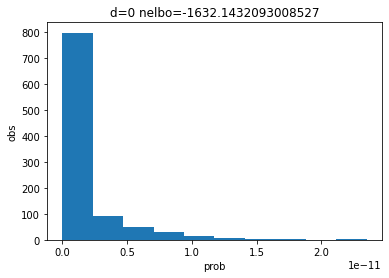

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,17032
nelbo,-1632.14321
entropy,-1350.61047
reconstruction_loss,281.53274
_runtime,324
_timestamp,1630699087
_step,17031


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▇▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▃▃▁▂▄▇██████████████████████████████████
reconstruction_loss,▁▂▃▄▅▆▇▇▇███████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 28559.2339116828; pi: tensor([0.3828, 0.2884, 0.3288], dtype=torch.float64)
NELBO: 1194.2132928599094; pi: tensor([0.3259, 0.3477, 0.3264], dtype=torch.float64)
NELBO: 451.6480790892829; pi: tensor([0.3272, 0.3433, 0.3294], dtype=torch.float64)
NELBO: -998.6336935604402; pi: tensor([0.3277, 0.3429, 0.3295], dtype=torch.float64)
NELBO: -1445.6439971055077; pi: tensor([0.3278, 0.3427, 0.3295], dtype=torch.float64)
NELBO: -1553.8533860362454; pi: tensor([0.3279, 0.3426, 0.3295], dtype=torch.float64)
NELBO: -1601.5418648091234; pi: tensor([0.3279, 0.3425, 0.3296], dtype=torch.float64)
NELBO: -1620.7271086274968; pi: tensor([0.3280, 0.3424, 0.3296], dtype=torch.float64)
trial: 1 NELBO: -1625.8863734291351 D: tensor([0.0036, 0.9964]) PI: tensor([0.3280, 0.3424, 0.3296], dtype=torch.float64)
{'log_mu': tensor([[-0.3359, -0.1101],
        [-0.8798, -0.2624],
        [-0.1953, -0.0459]], dtype=torch.float64, requires_grad=True), 'log_sigma': tensor([[-2.4039, -3.1176],
        [-3.2601, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


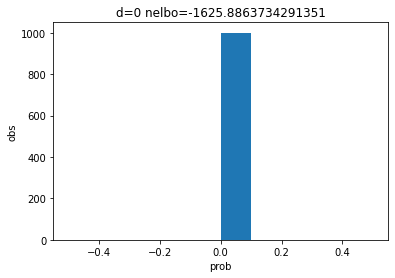

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,7865
nelbo,-1625.88637
entropy,-1349.6958
reconstruction_loss,276.19057
_runtime,150
_timestamp,1630699242
_step,7864


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅▅▅▅▅▅▅▅▅▅▇▇███████████████████████████
reconstruction_loss,▁▅▆▆▆▇▇▇▇▇▇▇▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 28281.613434144747; pi: tensor([0.2882, 0.3292, 0.3825], dtype=torch.float64)
NELBO: 2499.1950565976426; pi: tensor([0.1047, 0.4390, 0.4563], dtype=torch.float64)
NELBO: 686.8948397275367; pi: tensor([0.1028, 0.4384, 0.4588], dtype=torch.float64)
NELBO: 17.84567565857492; pi: tensor([0.1042, 0.4378, 0.4580], dtype=torch.float64)
NELBO: -964.6974223966156; pi: tensor([0.1056, 0.4372, 0.4572], dtype=torch.float64)
NELBO: -1339.7324511175752; pi: tensor([0.1069, 0.4367, 0.4564], dtype=torch.float64)
NELBO: -1373.745675900175; pi: tensor([0.1083, 0.4361, 0.4556], dtype=torch.float64)
NELBO: -1382.2488833340979; pi: tensor([0.1097, 0.4355, 0.4548], dtype=torch.float64)
NELBO: -1386.6645651407562; pi: tensor([0.1110, 0.4350, 0.4540], dtype=torch.float64)
NELBO: -1388.946202750959; pi: tensor([0.1124, 0.4344, 0.4532], dtype=torch.float64)
trial: 2 NELBO: -1389.8478350033683 D: tensor([0.0015, 0.9985]) PI: tensor([0.1133, 0.4340, 0.4527], dtype=torch.float64)
{'log_mu': tensor([[-0.7926

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


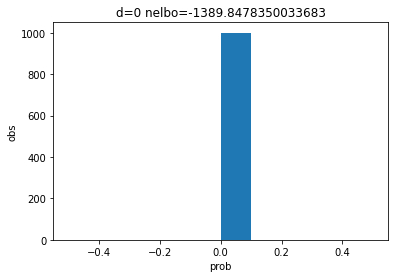

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,9651
nelbo,-1389.84784
entropy,-1492.70288
reconstruction_loss,-102.85505
_runtime,183
_timestamp,1630699430
_step,9650


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▃███▇▇▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
reconstruction_loss,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 32257.433527425987; pi: tensor([0.3832, 0.2876, 0.3292], dtype=torch.float64)
NELBO: 1340.3468342765373; pi: tensor([0.4778, 0.2009, 0.3213], dtype=torch.float64)
NELBO: -1814.1185347905257; pi: tensor([0.4791, 0.2009, 0.3200], dtype=torch.float64)
NELBO: -2899.9925588784613; pi: tensor([0.4788, 0.2009, 0.3203], dtype=torch.float64)
NELBO: -3420.974913621119; pi: tensor([0.4788, 0.2009, 0.3203], dtype=torch.float64)
NELBO: -3496.377131790072; pi: tensor([0.4789, 0.2009, 0.3203], dtype=torch.float64)
NELBO: -3501.6438195299907; pi: tensor([0.4789, 0.2008, 0.3203], dtype=torch.float64)
trial: 3 NELBO: -3502.629582910012 D: tensor([0.9458, 0.0542]) PI: tensor([0.4789, 0.2008, 0.3203], dtype=torch.float64)
{'log_mu': tensor([[-0.2021, -0.0432],
        [-0.9271, -0.2540],
        [-0.4485, -0.1577]], dtype=torch.float64, requires_grad=True), 'log_sigma': tensor([[-3.4571, -3.4507],
        [-3.4490, -3.4489],
        [-3.5050, -3.4627]], dtype=torch.float64, requires_grad=True), 'lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


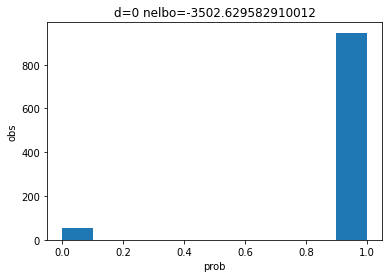

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,6541
nelbo,-3502.62958
entropy,-2156.70996
reconstruction_loss,1345.91962
_runtime,125
_timestamp,1630699560
_step,6540


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅██▇▇▆▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
reconstruction_loss,▁▅▆▆▆▆▆▆▇▇▇▇▇▇██████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 25043.07349480778; pi: tensor([0.3287, 0.3835, 0.2878], dtype=torch.float64)
NELBO: 871.2714228881141; pi: tensor([0.3994, 0.4876, 0.1130], dtype=torch.float64)
NELBO: -664.7616453267419; pi: tensor([0.8588, 0.1085, 0.0327], dtype=torch.float64)
NELBO: -1460.9252428773912; pi: tensor([0.9501, 0.0361, 0.0138], dtype=torch.float64)
NELBO: -1781.0471402669705; pi: tensor([0.9750, 0.0176, 0.0074], dtype=torch.float64)
NELBO: -1848.935172358926; pi: tensor([0.9859, 0.0098, 0.0044], dtype=torch.float64)
NELBO: -1856.6949598782548; pi: tensor([0.9916, 0.0057, 0.0027], dtype=torch.float64)
NELBO: 1475.4417665335204; pi: tensor([0.9949, 0.0035, 0.0017], dtype=torch.float64)
NELBO: -848.4129901078109; pi: tensor([0.9968, 0.0021, 0.0010], dtype=torch.float64)
NELBO: -1062.2395403914074; pi: tensor([9.9801e-01, 1.3305e-03, 6.5709e-04], dtype=torch.float64)
NELBO: -1174.281225912981; pi: tensor([9.9875e-01, 8.3322e-04, 4.1652e-04], dtype=torch.float64)
NELBO: -1231.0164228047033; pi: tensor(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


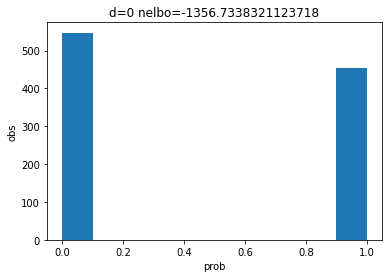

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,21014
nelbo,-1356.73383
entropy,-1967.68872
reconstruction_loss,-610.95489
_runtime,397
_timestamp,1630699962
_step,21013


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▅▃▂▂▁▁▁▁▁▁▁▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
entropy,▇▁▁▇█████████▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
reconstruction_loss,▁▃▃▆▇▇███████▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 29543.42675176992; pi: tensor([0.3288, 0.3828, 0.2884], dtype=torch.float64)
NELBO: 1091.3377635981474; pi: tensor([0.3207, 0.4343, 0.2450], dtype=torch.float64)
NELBO: -68.96555494967856; pi: tensor([0.3210, 0.4332, 0.2459], dtype=torch.float64)
NELBO: -971.8410454300285; pi: tensor([0.3212, 0.4321, 0.2467], dtype=torch.float64)
NELBO: -1336.7682162652297; pi: tensor([0.3214, 0.4311, 0.2475], dtype=torch.float64)
NELBO: -1532.4280180906485; pi: tensor([0.3216, 0.4301, 0.2483], dtype=torch.float64)
NELBO: -1581.6377349131808; pi: tensor([0.3218, 0.4292, 0.2491], dtype=torch.float64)
NELBO: -1605.1505518613221; pi: tensor([0.3220, 0.4282, 0.2498], dtype=torch.float64)
NELBO: -1613.3211026300444; pi: tensor([0.3222, 0.4272, 0.2506], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


trial: 5 NELBO: -1613.8861915677908 D: tensor([0.0039, 0.9961]) PI: tensor([0.3222, 0.4271, 0.2508], dtype=torch.float64)
{'log_mu': tensor([[-0.4396, -0.1472],
        [-0.1950, -0.0460],
        [-0.8811, -0.2623]], dtype=torch.float64, requires_grad=True), 'log_sigma': tensor([[-2.1613, -2.8237],
        [-3.4317, -3.4417],
        [-3.2742, -3.4258]], dtype=torch.float64, requires_grad=True), 'log_psi': tensor([5.0493, 3.9810, 3.8510], dtype=torch.float64, requires_grad=True), 'log_omega': tensor([ 1.6894, -0.7179,  0.9966], dtype=torch.float64, requires_grad=True), 'is_delta': tensor([-3.4946,  2.0365], requires_grad=True), 'is_pi': tensor([-1.0367, -0.7549, -1.2873], dtype=torch.float64, requires_grad=True), 'is_tau': tensor([[-5.0143, -1.1690, -4.6608],
        [-2.0068,  1.4596,  0.9655],
        [-2.7284, -1.3857,  0.5917]], dtype=torch.float64, requires_grad=True)}


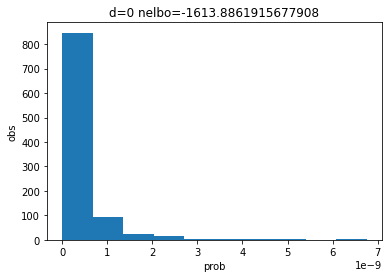

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,8165
nelbo,-1613.88619
entropy,-1217.82556
reconstruction_loss,396.06063
_runtime,157
_timestamp,1630700123
_step,8164


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▅▆▆▆▆▇▇▇▇▇▇▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 30416.436410148584; pi: tensor([0.2884, 0.3828, 0.3288], dtype=torch.float64)
NELBO: 1053.0186938733304; pi: tensor([0.2848, 0.4066, 0.3086], dtype=torch.float64)
NELBO: 21.52558986758345; pi: tensor([0.2853, 0.4058, 0.3089], dtype=torch.float64)
NELBO: -1078.8644118028228; pi: tensor([0.2858, 0.4050, 0.3092], dtype=torch.float64)
NELBO: -1439.4328200757545; pi: tensor([0.2863, 0.4043, 0.3094], dtype=torch.float64)
NELBO: -1554.3692568990598; pi: tensor([0.2867, 0.4036, 0.3097], dtype=torch.float64)
NELBO: -1602.5118007390038; pi: tensor([0.2872, 0.4028, 0.3100], dtype=torch.float64)
NELBO: -1621.1896527033564; pi: tensor([0.2877, 0.4021, 0.3102], dtype=torch.float64)
NELBO: -1626.0145939701963; pi: tensor([0.2881, 0.4014, 0.3105], dtype=torch.float64)
NELBO: -1628.270573082958; pi: tensor([0.2886, 0.4007, 0.3107], dtype=torch.float64)
NELBO: -1629.9756145335252; pi: tensor([0.2890, 0.4000, 0.3110], dtype=torch.float64)
NELBO: -1630.7947683734994; pi: tensor([0.2894, 0.3993, 0.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


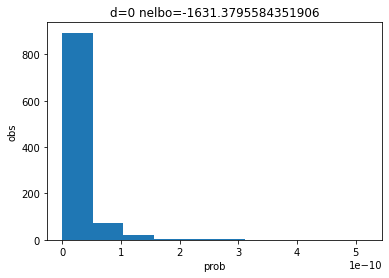

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12155
nelbo,-1631.37956
entropy,-1338.60291
reconstruction_loss,292.77665
_runtime,231
_timestamp,1630700359
_step,12154


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▁▁▁▁▂▅▇████████████████████████████████
reconstruction_loss,▁▄▄▅▅▅▆▇▇▇▇█████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 31897.360463751887; pi: tensor([0.3292, 0.3825, 0.2882], dtype=torch.float64)
NELBO: 279.92688002509476; pi: tensor([0.1283, 0.7884, 0.0833], dtype=torch.float64)
NELBO: -543.5250851361523; pi: tensor([0.0438, 0.9258, 0.0304], dtype=torch.float64)
NELBO: -1399.4974478381334; pi: tensor([0.0191, 0.9663, 0.0146], dtype=torch.float64)
NELBO: -1754.4018185125556; pi: tensor([0.0101, 0.9819, 0.0081], dtype=torch.float64)
NELBO: -1896.8738980336195; pi: tensor([0.0058, 0.9895, 0.0047], dtype=torch.float64)
NELBO: -1994.9054671142608; pi: tensor([0.0035, 0.9936, 0.0029], dtype=torch.float64)
NELBO: -2287.5964424745866; pi: tensor([0.0021, 0.9961, 0.0018], dtype=torch.float64)
NELBO: -2290.6348598526315; pi: tensor([0.0013, 0.9976, 0.0011], dtype=torch.float64)
trial: 7 NELBO: -2291.8186396230826 D: tensor([0.4545, 0.5455]) PI: tensor([8.8911e-04, 9.9835e-01, 7.6053e-04], dtype=torch.float64)
{'log_mu': tensor([[-0.1266, -0.0708],
        [-0.2162, -0.0499],
        [-0.9277, -0.2537]],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


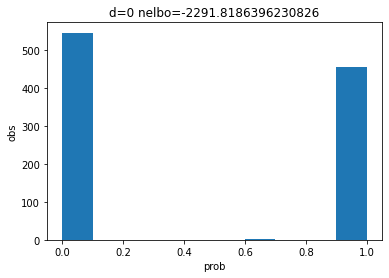

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,8829
nelbo,-2291.81864
entropy,-1805.74011
reconstruction_loss,486.07853
_runtime,167
_timestamp,1630700530
_step,8828


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁█▆▄▄▄▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆
reconstruction_loss,▁▅▆▆▆▆▆▇▇▇▇▇▇▇██████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 31017.408128746247; pi: tensor([0.3825, 0.3292, 0.2882], dtype=torch.float64)
NELBO: 1296.8221699928636; pi: tensor([0.3262, 0.4133, 0.2605], dtype=torch.float64)
NELBO: 540.7728450637696; pi: tensor([0.3264, 0.4125, 0.2612], dtype=torch.float64)
NELBO: 153.56694283943716; pi: tensor([0.3265, 0.4117, 0.2618], dtype=torch.float64)
NELBO: -146.49212487094178; pi: tensor([0.3266, 0.4109, 0.2625], dtype=torch.float64)
NELBO: -303.8343438405177; pi: tensor([0.3267, 0.4101, 0.2632], dtype=torch.float64)
NELBO: -328.51047934889834; pi: tensor([0.3268, 0.4093, 0.2638], dtype=torch.float64)
NELBO: -335.13504535245465; pi: tensor([0.3270, 0.4085, 0.2645], dtype=torch.float64)
NELBO: -338.92141596328406; pi: tensor([0.3271, 0.4078, 0.2651], dtype=torch.float64)
NELBO: -341.3857076161544; pi: tensor([0.3272, 0.4070, 0.2658], dtype=torch.float64)
NELBO: -343.11526769689317; pi: tensor([0.3273, 0.4063, 0.2664], dtype=torch.float64)
NELBO: -344.45502358045337; pi: tensor([0.3274, 0.4055, 0.267

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


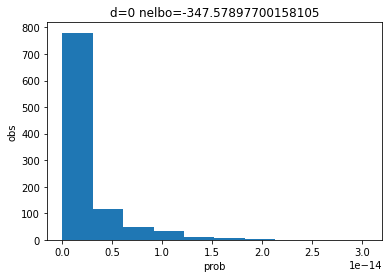

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,17330
nelbo,-347.57898
entropy,-1745.45789
reconstruction_loss,-1397.87891
_runtime,331
_timestamp,1630700865
_step,17329


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
reconstruction_loss,▁▄▆▆▇▇▇▇████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 27249.07871006342; pi: tensor([0.2878, 0.3827, 0.3294], dtype=torch.float64)
NELBO: 1103.2338343149863; pi: tensor([0.2017, 0.4123, 0.3860], dtype=torch.float64)
NELBO: 294.93345125401174; pi: tensor([0.2028, 0.4116, 0.3856], dtype=torch.float64)
NELBO: -903.2308256731326; pi: tensor([0.2039, 0.4109, 0.3852], dtype=torch.float64)
NELBO: -1336.8376032090323; pi: tensor([0.2049, 0.4102, 0.3848], dtype=torch.float64)
NELBO: -1575.0553539669518; pi: tensor([0.2060, 0.4095, 0.3845], dtype=torch.float64)
NELBO: -1613.9526939656403; pi: tensor([0.2071, 0.4089, 0.3841], dtype=torch.float64)
NELBO: -1623.3462115613358; pi: tensor([0.2081, 0.4082, 0.3837], dtype=torch.float64)
NELBO: -1627.0985188763293; pi: tensor([0.2092, 0.4075, 0.3833], dtype=torch.float64)
NELBO: -1628.9804263081728; pi: tensor([0.2103, 0.4069, 0.3829], dtype=torch.float64)
NELBO: -1630.2144249032917; pi: tensor([0.2113, 0.4062, 0.3825], dtype=torch.float64)
NELBO: -1630.954891182298; pi: tensor([0.2123, 0.4056, 0.38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


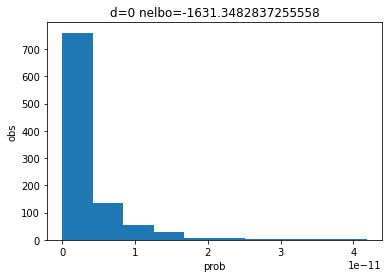

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11862
nelbo,-1631.34828
entropy,-1324.46277
reconstruction_loss,306.88552
_runtime,231
_timestamp,1630701101
_step,11861


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▄▁▁▁▂▄▆▇███████████████████████████████
reconstruction_loss,▁▄▅▅▅▅▆▆▇▇▇█████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 33130.05056363321; pi: tensor([0.3825, 0.2882, 0.3292], dtype=torch.float64)
NELBO: 991.4472960482567; pi: tensor([0.3319, 0.3016, 0.3664], dtype=torch.float64)
NELBO: -216.9112898355354; pi: tensor([0.3320, 0.3020, 0.3660], dtype=torch.float64)
NELBO: -1083.5383140154165; pi: tensor([0.3321, 0.3023, 0.3656], dtype=torch.float64)
NELBO: -1470.1588021567643; pi: tensor([0.3321, 0.3026, 0.3653], dtype=torch.float64)
NELBO: -1600.7323848478613; pi: tensor([0.3321, 0.3029, 0.3650], dtype=torch.float64)
NELBO: -1616.2462831405014; pi: tensor([0.3321, 0.3032, 0.3646], dtype=torch.float64)
NELBO: -1623.6042312843445; pi: tensor([0.3321, 0.3035, 0.3643], dtype=torch.float64)
NELBO: -1627.7740983279814; pi: tensor([0.3322, 0.3038, 0.3640], dtype=torch.float64)
NELBO: -1629.520861095078; pi: tensor([0.3322, 0.3041, 0.3637], dtype=torch.float64)
NELBO: -1630.5106560184047; pi: tensor([0.3322, 0.3044, 0.3634], dtype=torch.float64)
trial: 10 NELBO: -1630.5694611736153 D: tensor([0.0014, 0.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


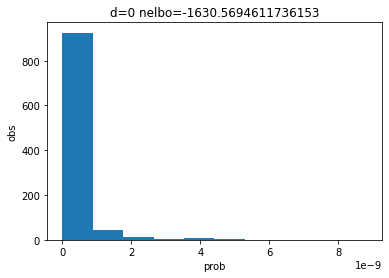

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10044
nelbo,-1630.56946
entropy,-1350.05322
reconstruction_loss,280.51624
_runtime,195
_timestamp,1630701300
_step,10043


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▆▆▆▇▇▇▇████████████████████████████████
reconstruction_loss,▁▅▆▆▆▇▇▇▇▇▇█████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 31806.558835553005; pi: tensor([0.2878, 0.3827, 0.3294], dtype=torch.float64)
NELBO: 972.4488873038194; pi: tensor([0.2412, 0.3700, 0.3888], dtype=torch.float64)
NELBO: -195.91992593976556; pi: tensor([0.2421, 0.3697, 0.3882], dtype=torch.float64)
NELBO: -1076.269060177965; pi: tensor([0.2429, 0.3694, 0.3877], dtype=torch.float64)
NELBO: -1452.5956554493064; pi: tensor([0.2437, 0.3691, 0.3872], dtype=torch.float64)
NELBO: -1598.9692006877267; pi: tensor([0.2445, 0.3688, 0.3867], dtype=torch.float64)
NELBO: -1616.0535596147527; pi: tensor([0.2453, 0.3685, 0.3862], dtype=torch.float64)
NELBO: -1623.6239560580589; pi: tensor([0.2461, 0.3682, 0.3857], dtype=torch.float64)
NELBO: -1627.4655899326137; pi: tensor([0.2469, 0.3679, 0.3852], dtype=torch.float64)
NELBO: -1629.291280320463; pi: tensor([0.2477, 0.3676, 0.3847], dtype=torch.float64)
NELBO: -1630.3610903983026; pi: tensor([0.2485, 0.3673, 0.3843], dtype=torch.float64)
NELBO: -1630.9700101666185; pi: tensor([0.2492, 0.3670, 0.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


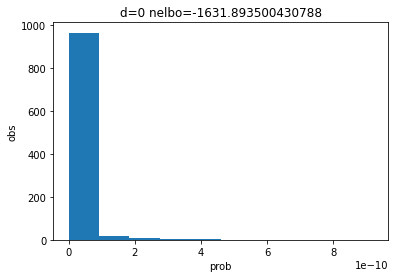

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13783
nelbo,-1631.8935
entropy,-1348.93982
reconstruction_loss,282.95368
_runtime,265
_timestamp,1630701570
_step,13782


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▃▂▁▃▆▇█████████████████████████████████
reconstruction_loss,▁▄▅▅▆▆▇▇▇███████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 27520.100208941687; pi: tensor([0.3825, 0.2882, 0.3292], dtype=torch.float64)
NELBO: 1035.5176384648262; pi: tensor([0.4461, 0.0934, 0.4605], dtype=torch.float64)
NELBO: -578.595918546424; pi: tensor([0.9137, 0.0204, 0.0659], dtype=torch.float64)
NELBO: -1373.869123696985; pi: tensor([0.9695, 0.0086, 0.0219], dtype=torch.float64)
NELBO: -1654.9906375359828; pi: tensor([0.9846, 0.0046, 0.0108], dtype=torch.float64)
NELBO: -1723.5431356958004; pi: tensor([0.9912, 0.0027, 0.0060], dtype=torch.float64)
NELBO: -1757.1310873328484; pi: tensor([0.9948, 0.0017, 0.0036], dtype=torch.float64)
NELBO: -2125.8479073988146; pi: tensor([0.9968, 0.0010, 0.0022], dtype=torch.float64)
NELBO: -2281.961706252826; pi: tensor([9.9801e-01, 6.5020e-04, 1.3415e-03], dtype=torch.float64)
NELBO: -2291.8907799923663; pi: tensor([9.9875e-01, 4.1118e-04, 8.3746e-04], dtype=torch.float64)
NELBO: -2292.988181320693; pi: tensor([9.9921e-01, 2.6067e-04, 5.2584e-04], dtype=torch.float64)
trial: 12 NELBO: -2293.18

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


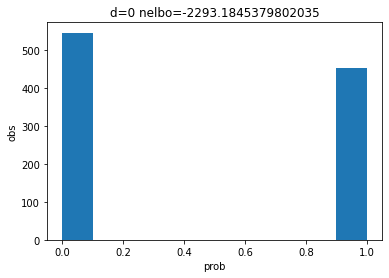

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10681
nelbo,-2293.18454
entropy,-1806.18896
reconstruction_loss,486.99557
_runtime,204
_timestamp,1630701779
_step,10680


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅▅▅▅▅▇█████████████████████████████████
reconstruction_loss,▁▆▆▆▆▆▇▇▇▇▇█████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 31160.616214176218; pi: tensor([0.3292, 0.3825, 0.2882], dtype=torch.float64)
NELBO: 1148.1403702224152; pi: tensor([0.3651, 0.3946, 0.2402], dtype=torch.float64)
NELBO: 372.4318217476557; pi: tensor([0.3649, 0.3940, 0.2411], dtype=torch.float64)
NELBO: -972.6955492488655; pi: tensor([0.3646, 0.3934, 0.2420], dtype=torch.float64)
NELBO: -1334.693090368489; pi: tensor([0.3644, 0.3928, 0.2428], dtype=torch.float64)
NELBO: -1565.250941300677; pi: tensor([0.3641, 0.3923, 0.2436], dtype=torch.float64)
NELBO: -1609.4827774221974; pi: tensor([0.3639, 0.3917, 0.2444], dtype=torch.float64)
NELBO: -1622.1805772995167; pi: tensor([0.3636, 0.3912, 0.2452], dtype=torch.float64)
NELBO: -1626.5695222142365; pi: tensor([0.3634, 0.3906, 0.2460], dtype=torch.float64)
trial: 13 NELBO: -1628.4363308515224 D: tensor([0.0026, 0.9974]) PI: tensor([0.3632, 0.3902, 0.2467], dtype=torch.float64)
{'log_mu': tensor([[-0.3399, -0.1116],
        [-0.1953, -0.0459],
        [-0.8802, -0.2624]], dtype=torch.fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


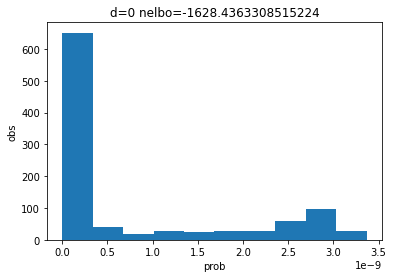

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,8830
nelbo,-1628.43633
entropy,-1350.55322
reconstruction_loss,277.88311
_runtime,172
_timestamp,1630701956
_step,8829


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▅▄▅▅▄▄▄▅▆▇▇████████████████████████████
reconstruction_loss,▁▄▅▅▅▆▆▆▆▆▇▇▇▇██████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 28415.169244736862; pi: tensor([0.3827, 0.2878, 0.3294], dtype=torch.float64)
NELBO: 1275.0707890790713; pi: tensor([0.3447, 0.2536, 0.4017], dtype=torch.float64)
NELBO: 697.1016182140092; pi: tensor([0.3446, 0.2544, 0.4010], dtype=torch.float64)
NELBO: 467.02630737467325; pi: tensor([0.3446, 0.2551, 0.4003], dtype=torch.float64)
NELBO: -507.3101560624357; pi: tensor([0.3445, 0.2558, 0.3997], dtype=torch.float64)
NELBO: -1238.3457057133478; pi: tensor([0.3445, 0.2565, 0.3990], dtype=torch.float64)
NELBO: -1367.3047612518546; pi: tensor([0.3444, 0.2572, 0.3983], dtype=torch.float64)
NELBO: -1377.6406284280333; pi: tensor([0.3444, 0.2579, 0.3977], dtype=torch.float64)
NELBO: -1382.7378648922604; pi: tensor([0.3443, 0.2586, 0.3971], dtype=torch.float64)
NELBO: -1386.1682403544223; pi: tensor([0.3442, 0.2593, 0.3964], dtype=torch.float64)
NELBO: -1389.6191896972396; pi: tensor([0.3442, 0.2600, 0.3958], dtype=torch.float64)
NELBO: -1390.5775969029996; pi: tensor([0.3441, 0.2607, 0.39

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


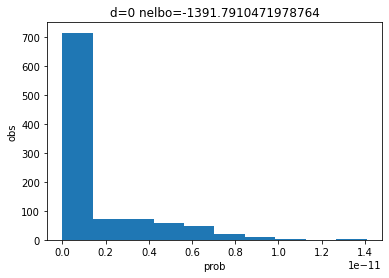

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13766
nelbo,-1391.79105
entropy,-1491.80823
reconstruction_loss,-100.01718
_runtime,257
_timestamp,1630702217
_step,13765


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▄▂▂▂▂▄▅▆▆▇▇████████████████████████████
reconstruction_loss,▁▄▅▆▆▆▆▆▆▆▇▇▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 36635.7455229627; pi: tensor([0.3288, 0.3828, 0.2884], dtype=torch.float64)
NELBO: 545.2012261655423; pi: tensor([0.3971, 0.5197, 0.0832], dtype=torch.float64)
NELBO: -511.6819663456415; pi: tensor([0.0489, 0.9284, 0.0228], dtype=torch.float64)
NELBO: -1191.8155496776312; pi: tensor([0.0178, 0.9719, 0.0103], dtype=torch.float64)
NELBO: -1549.9452202080106; pi: tensor([0.0089, 0.9854, 0.0057], dtype=torch.float64)
NELBO: -1769.24324895091; pi: tensor([0.0050, 0.9916, 0.0033], dtype=torch.float64)
NELBO: -1837.017406343818; pi: tensor([0.0030, 0.9950, 0.0021], dtype=torch.float64)
NELBO: -1907.3069367432654; pi: tensor([0.0018, 0.9969, 0.0013], dtype=torch.float64)
NELBO: -1913.1411177884604; pi: tensor([1.1149e-03, 9.9808e-01, 8.0492e-04], dtype=torch.float64)
NELBO: -1915.4704815284836; pi: tensor([6.9580e-04, 9.9880e-01, 5.0879e-04], dtype=torch.float64)
NELBO: -1916.6511340626062; pi: tensor([4.3688e-04, 9.9924e-01, 3.2239e-04], dtype=torch.float64)
NELBO: -1917.3625925680133;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


trial: 15 NELBO: -1918.2043309387318 D: tensor([0.4534, 0.5466]) PI: tensor([6.6399e-05, 9.9988e-01, 4.9698e-05], dtype=torch.float64)
{'log_mu': tensor([[-0.1322, -0.0736],
        [-0.2059, -0.0449],
        [-0.9269, -0.2533]], dtype=torch.float64, requires_grad=True), 'log_sigma': tensor([[-3.1809, -3.3831],
        [-3.3424, -3.4290],
        [-3.4686, -3.4517]], dtype=torch.float64, requires_grad=True), 'log_psi': tensor([4.1787, 4.6729, 3.7851], dtype=torch.float64, requires_grad=True), 'log_omega': tensor([ 3.1388,  0.0418, -0.7387], dtype=torch.float64, requires_grad=True), 'is_delta': tensor([-0.7804, -0.5935], requires_grad=True), 'is_pi': tensor([-5.1882,  4.4315, -5.4779], dtype=torch.float64, requires_grad=True), 'is_tau': tensor([[-6.2382, -5.3998,  2.2815],
        [-5.4022,  0.7239, -5.9130],
        [ 2.2949, -5.9040,  2.4519]], dtype=torch.float64, requires_grad=True)}


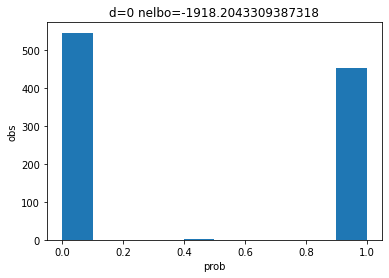

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14106
nelbo,-1918.20433
entropy,-1820.86938
reconstruction_loss,97.33495
_runtime,257
_timestamp,1630702479
_step,14105


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▄▃▃▆▇████████▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▅▆▆▇▇▇▇████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 26122.993781649333; pi: tensor([0.2878, 0.3827, 0.3294], dtype=torch.float64)
NELBO: 1146.9378572202804; pi: tensor([0.2176, 0.3685, 0.4139], dtype=torch.float64)
NELBO: 12.953821500968843; pi: tensor([0.2191, 0.3682, 0.4126], dtype=torch.float64)
NELBO: -987.7500839539487; pi: tensor([0.2202, 0.3680, 0.4118], dtype=torch.float64)
NELBO: -1400.3376353883805; pi: tensor([0.2212, 0.3677, 0.4111], dtype=torch.float64)
NELBO: -1594.0560341159965; pi: tensor([0.2222, 0.3675, 0.4103], dtype=torch.float64)
NELBO: -1617.4356567821405; pi: tensor([0.2231, 0.3672, 0.4096], dtype=torch.float64)
NELBO: -1624.3922132242812; pi: tensor([0.2241, 0.3670, 0.4089], dtype=torch.float64)
NELBO: -1627.7254248471604; pi: tensor([0.2250, 0.3668, 0.4082], dtype=torch.float64)
NELBO: -1629.4219893571053; pi: tensor([0.2260, 0.3665, 0.4075], dtype=torch.float64)
NELBO: -1630.4489596810677; pi: tensor([0.2269, 0.3663, 0.4068], dtype=torch.float64)
trial: 16 NELBO: -1630.9253523013415 D: tensor([0.0011, 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


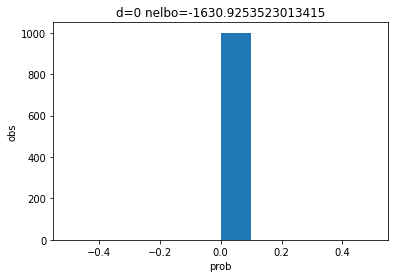

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10668
nelbo,-1630.92535
entropy,-1348.2356
reconstruction_loss,282.68976
_runtime,199
_timestamp,1630702682
_step,10667


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▆▅▂▂▃▅▆▇███████████████████████████████
reconstruction_loss,▁▄▅▅▅▆▆▆▇▇▇█████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 29001.57083765576; pi: tensor([0.2876, 0.3832, 0.3292], dtype=torch.float64)
NELBO: -338.88485519789856; pi: tensor([0.2020, 0.4781, 0.3198], dtype=torch.float64)
NELBO: -1955.0222023800595; pi: tensor([0.2009, 0.4789, 0.3202], dtype=torch.float64)
NELBO: -2947.2466213988337; pi: tensor([0.2009, 0.4789, 0.3202], dtype=torch.float64)
NELBO: -3448.6610825381686; pi: tensor([0.2009, 0.4789, 0.3203], dtype=torch.float64)
NELBO: -3492.1835605244223; pi: tensor([0.2009, 0.4789, 0.3203], dtype=torch.float64)
NELBO: -3494.4736106944124; pi: tensor([0.2009, 0.4789, 0.3203], dtype=torch.float64)
trial: 17 NELBO: -3494.958020560243 D: tensor([0.9457, 0.0543]) PI: tensor([0.2008, 0.4789, 0.3203], dtype=torch.float64)
{'log_mu': tensor([[-0.9268, -0.2542],
        [-0.2021, -0.0433],
        [-0.4485, -0.1577]], dtype=torch.float64, requires_grad=True), 'log_sigma': tensor([[-3.4555, -3.4500],
        [-3.4546, -3.4527],
        [-3.5019, -3.4614]], dtype=torch.float64, requires_grad=True), 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


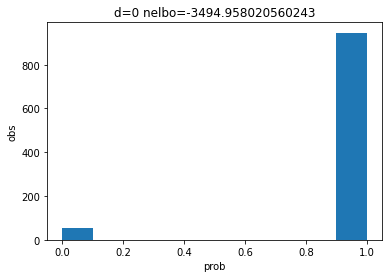

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,6837
nelbo,-3494.95802
entropy,-2136.9187
reconstruction_loss,1358.03932
_runtime,128
_timestamp,1630702814
_step,6836


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▇██▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
reconstruction_loss,▁▅▆▆▆▇▇▇▇▇▇▇▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 28588.24122213333; pi: tensor([0.3825, 0.2882, 0.3292], dtype=torch.float64)
NELBO: 874.7445348292886; pi: tensor([0.4144, 0.0896, 0.4960], dtype=torch.float64)
NELBO: -697.8648428556862; pi: tensor([0.0497, 0.0193, 0.9311], dtype=torch.float64)
NELBO: -1378.3797003199124; pi: tensor([0.0199, 0.0087, 0.9714], dtype=torch.float64)
NELBO: -1732.6505769451724; pi: tensor([0.0103, 0.0047, 0.9850], dtype=torch.float64)
NELBO: -1842.1242870652104; pi: tensor([0.0058, 0.0028, 0.9914], dtype=torch.float64)
NELBO: -1857.100893213648; pi: tensor([0.0035, 0.0017, 0.9948], dtype=torch.float64)
NELBO: -1860.1803678748256; pi: tensor([0.0021, 0.0011, 0.9968], dtype=torch.float64)
NELBO: -1862.2351362121872; pi: tensor([1.3228e-03, 6.6019e-04, 9.9802e-01], dtype=torch.float64)
NELBO: -1916.5886327059425; pi: tensor([8.2794e-04, 4.1651e-04, 9.9876e-01], dtype=torch.float64)
NELBO: -1917.037822793487; pi: tensor([5.2094e-04, 2.6359e-04, 9.9922e-01], dtype=torch.float64)
trial: 18 NELBO: -1917.38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


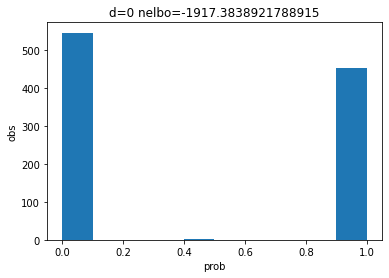

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10764
nelbo,-1917.38389
entropy,-1819.75208
reconstruction_loss,97.63182
_runtime,203
_timestamp,1630703022
_step,10763


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂▄▂▁▃▆▇███████████████████████▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▄▅▅▆▆▇▇▇▇██████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 33400.616414594595; pi: tensor([0.3292, 0.3825, 0.2882], dtype=torch.float64)
NELBO: 856.0537972372622; pi: tensor([0.4921, 0.4208, 0.0871], dtype=torch.float64)
NELBO: -723.8912633343937; pi: tensor([0.9290, 0.0504, 0.0206], dtype=torch.float64)
NELBO: -1391.2380204624244; pi: tensor([0.9713, 0.0195, 0.0092], dtype=torch.float64)
NELBO: -1732.043476845738; pi: tensor([0.9851, 0.0100, 0.0050], dtype=torch.float64)
NELBO: -1842.4444519796548; pi: tensor([0.9914, 0.0057, 0.0029], dtype=torch.float64)
NELBO: -1857.2466299860876; pi: tensor([0.9948, 0.0034, 0.0018], dtype=torch.float64)
NELBO: -1860.4250749519292; pi: tensor([0.9968, 0.0021, 0.0011], dtype=torch.float64)
NELBO: -1862.282172958048; pi: tensor([9.9801e-01, 1.2889e-03, 6.9746e-04], dtype=torch.float64)
NELBO: -1906.4488481443548; pi: tensor([9.9875e-01, 8.0747e-04, 4.4005e-04], dtype=torch.float64)
NELBO: -1916.9996857619863; pi: tensor([9.9921e-01, 5.0811e-04, 2.7842e-04], dtype=torch.float64)
NELBO: -1917.50010190157

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


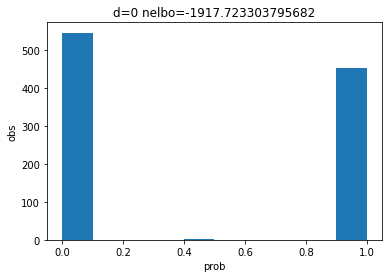

In [10]:
for trial in range(nt):
  
  Y = np.array(Y)
  S = np.array(S)
  kms = [KMeans(nc).fit(Y) for i in range(N_INIT)]
  inertias = [k.inertia_ for k in kms]
  km = kms[np.argmin(np.array(inertias))] ## selected "best" kmeans based on inertia score
  init_labels = km.labels_
  
  mu_init = np.array([Y[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
  sigma_init = np.array([Y[init_labels == i,:].std(0) for i in np.unique(init_labels)])
  psi_init = np.array([S[init_labels == i].mean() for i in np.unique(init_labels)])
  omega_init = np.array([S[init_labels == i].std() for i in np.unique(init_labels)])
  pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
  tau_init = np.ones((nc,nc))
  tau_init = tau_init / tau_init.sum()

  Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": F.log_softmax(torch.tensor([0.95, 1-0.95])),
    'is_pi': F.log_softmax(torch.tensor(pi_init)),
    'is_tau': F.log_softmax(torch.tensor(tau_init))
  }
  Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

  #Theta['is_delta'].requires_grad = False
  #Theta['is_pi'].requires_grad = False
  #Theta['is_tau'].requires_grad = False

  r_net = BasicForwardNet(P, nc, 10)
  v_net = BasicForwardNet(P, nc ** 2, 50)
  d_net = BasicForwardNet(P, 2, 5)

  Y = torch.tensor(Y)
  S = torch.tensor(S)
  YS = torch.hstack((Y,S.reshape(-1,1))).float()
  YS1 = (YS - YS.mean(0)) / YS.std(0)

  params = list(Theta.values()) + list(r_net.parameters()) + list(v_net.parameters()) + list(d_net.parameters())
  opt = optim.AdamW(params, lr=lr)

  wandb.init(project='jett-vi_YS1_lr1e-3_hd20',
           config={
    "N_EPOCHS": N_ITER,
    "LR": lr,
    "TOL": tol,
    'MODEL_TYPE': 'vi',
    'DATA_TYPE': 'toy_data'
  })

  loss = []
  for i in range(N_ITER):
  
    opt.zero_grad()
    r, log_r = r_net(YS1)
    v, log_v = v_net(YS1)
    d, log_d = d_net(YS1)
  
    ## row sums to 1 (from neural net)
    log_q0 = log_d[:,0].reshape(-1,1) + log_r ## like r in em version
    log_q1 = log_d[:,1].reshape(-1,1) + log_v ## like v in em version
    
    log_rzd0, log_vgd1 = compute_joint_probs(Theta, Y, S)

    entro = (d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
    recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()

    #entro = (log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()
    #recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()
    nelbo = entro - recon

    #nelbo = (log_q0.exp() * (log_q0 - log_rzd0)).sum() + (log_q1.exp() * (log_q1 - log_vgd1)).sum()

    nelbo.backward()
    opt.step()
  
    wandb.log({
      'ITER': i + 1, 
      'nelbo': nelbo.detach(),
      'entropy': entro.detach(),
      'reconstruction_loss': recon.detach(),
      'log_mu': Theta['log_mu'],
      'log_sigma': Theta['log_sigma'], #np.zeros_like(sigma_init),
      'log_psi': Theta['log_psi'],
      'log_omega': Theta['log_omega'],
      "is_delta": Theta['is_delta'],
      'is_pi': Theta['is_pi'],
      'is_tau': Theta['is_tau'],
      'r': r,
      'v': v,
      'd': d,
      })
  
    if i % (1000 - 1) == 0:
      #print("NELBO: {}; lambda: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      #print("NELBO: {}; entro: {}; recon: {}; pi: {}".format(nelbo.detach(), entro.detach(), recon.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      print("NELBO: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  
    if i > 0 and abs(loss[-1] - nelbo.detach()) < tol:
      break
           
    loss.append(nelbo.detach())

  print("trial: {} NELBO: {} D: {} PI: {}".format(trial, nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  print(Theta)

  plt.figure()
  plt.hist(np.array(d.T[0].detach().numpy()))
  plt.title('d=0 nelbo={}'.format(nelbo.detach()))
  plt.xlabel('prob')
  plt.ylabel('obs')
  plt.show()

In [11]:
np.exp(theta_true['log_lambda0'])

0.946

In [12]:
np.exp(theta_true['log_pi'])

array([0.21359429, 0.32852774, 0.45787797])

In [13]:
np.exp(theta_true['log_mu'])

array([[0.39613271, 0.77499654],
       [0.63653017, 0.85344703],
       [0.81497041, 0.95777742]])

In [15]:
np.exp(np.array([[-0.2021, -0.0432],
  [-0.9271, -0.2540],
  [-0.4485, -0.1577]]))

array([[0.81701322, 0.95771983],
       [0.39569958, 0.7756918 ],
       [0.63858531, 0.85410598]])